# Predictions with Multiple Algorithms

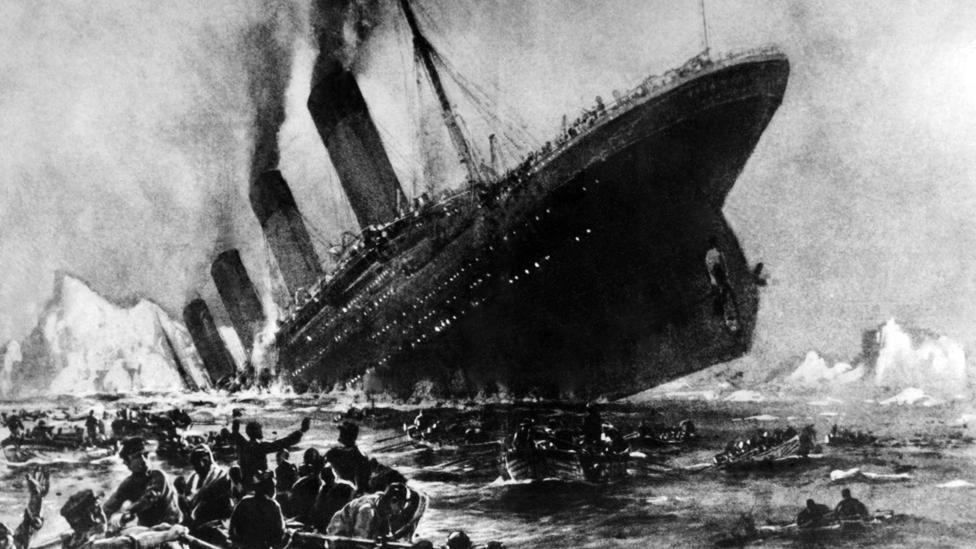

### Import Libraries

In [ ]:
# Basic packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats; from scipy.stats import zscore, norm, randint
import matplotlib.style as style; style.use('fivethirtyeight')
from sklearn.impute import SimpleImputer
%matplotlib inline

# Modelling - LR, KNN, NB, Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

# Display settings
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

random_state = 44
np.random.seed(random_state)

<a id='Data'></a>
# ** Load data and overview**

In [ ]:
import pandas as pd
test_data= pd.read_csv("../input/titanic/test.csv")
train_data = pd.read_csv("../input/titanic/train.csv")
result = test_data['PassengerId']

### Display top 5 records

In [ ]:
train_data.head()

### Display name of columns

In [ ]:
train_data.columns


### Get Info of dataframe Columns

In [ ]:
train_data.info()

### Shape of Dataset

In [ ]:
print('Shape of training data: ' +str(train_data.shape))
print('Shape of testing data: ' +str(test_data.shape))

## Exploratory Data Analysis¶
* Get descriptive statistics including five point summary
* Comment on the types of variables in dataset and descriptive statistics observation
* Check unique values in class columns
* Check distribution of class column
* Check missing values in the dataframe and impute those missing values
* Univariate and Bivariate visualization: Looking at one feature at a time to understand how are the values are distributed, checking outliers and relation of the columns with class
* Handle outliers using SimpleImputer
* Multivariate visualization including correlation and scatterplot matrix. In the process identify the features to be taken further for the study
* Handle imbalance in no of observations in target(class) varable.


### **Five point summary of numerical attributes and check unique values in 'object' columns**

In [ ]:
# Five point summary
train_data.describe(include = 'all').T

### Checking the distribution of class variable

In [ ]:
train_data["Survived"].value_counts().plot(kind='barh')


In [ ]:
display(train_data['Survived'].value_counts(), train_data['Survived'].value_counts(normalize = True)*100)

In [ ]:
train_data['Pclass'].value_counts()

### Handling missing values

In [ ]:
# Check missing values in the dataframe
train_data.isnull().sum()

In [ ]:
train_data.isnull().sum()

In [ ]:
null_columns = train_data.columns[train_data.isnull().any()];
null_columns

In [ ]:
print('Descriptive Stats before imputation for columns with missing values: \n', '--'*35)
display(train_data['Age'].describe().T)

train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())

print('Descriptive Stats after imputation: \n', '--'*35)
display(train_data['Age'].describe().T)


In [ ]:
##Droping some columns which are not going to help in predictions
train_data["familySize"] = train_data["SibSp"]+train_data["Parch"]+1
test_data["familySize"] = test_data["SibSp"]+train_data["Parch"]+1
train_data_1 = train_data.drop(["Ticket","Name","Cabin","SibSp","Parch", "PassengerId"],axis = 1)
test_data_1 = test_data.drop(["Ticket","Name","Cabin","SibSp","Parch", "PassengerId"],axis = 1)


In [ ]:
replace_values =  {'male': 0, 'female': 1}
train_data_1['Sex'] = train_data_1['Sex'].map(replace_values)
rep_val1= {'S': 0, 'C': 1, 'Q': 2}
train_data_1['Embarked'] = train_data_1['Embarked'].map(rep_val1)
test_data_1['Sex'] = test_data_1['Sex'].map(replace_values)
test_data_1['Embarked'] = test_data_1['Embarked'].map(rep_val1)

In [ ]:
test_data_1.columns

In [ ]:
train_data_1['Sex'].value_counts()

#### Custom Helper functions in EDA

In [ ]:
def target_count(df, col1, col2):
    fig = plt.figure(figsize = (15, 7.2))
    ax = fig.add_subplot(121)
    sns.countplot(x = col1, data = df, palette = ['tab:blue', 'tab:cyan'], ax = ax, orient = 'v',
                  hue = 'Survived').set_title(col1.capitalize() +' count plot by Target', 
                                                                      fontsize = 13)
    plt.legend(labels = ['Survived', 'Died'])
    plt.xticks(rotation = 90)
    
    ax = fig.add_subplot(122)
    sns.countplot(x = col2, data = df, palette = ['tab:blue', 'tab:cyan'], ax = ax, orient = 'v', 
                  hue = 'Survived').set_title(col2.capitalize() +' coount plot by Target', 
                                                                      fontsize = 13)
    plt.legend(labels = ['Survived', 'Died'])
    plt.xticks(rotation = 90)
    return plt.show()

def odp_plots(df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    
    # Boxplot to check outliers
    sns.boxplot(x = col, data = df, ax = ax1, orient = 'v', color = 'darkslategrey')
    
    # Distribution plot with outliers
    sns.distplot(df[col], ax = ax2, color = 'teal', fit = norm).set_title(f'Distribution of {col} with outliers')
    
    # Removing outliers, but in a new dataframe
    upperbound, lowerbound = np.percentile(df[col], [1, 99])
    y = pd.DataFrame(np.clip(df[col], upperbound, lowerbound))
    
    # Distribution plot without outliers
    sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm).set_title(f'Distribution of {col} without outliers')
    
    kwargs = {'fontsize':14, 'color':'black'}
    ax1.set_title(col + ' Boxplot Analysis', **kwargs)
    ax1.set_xlabel('Box', **kwargs)
    ax1.set_ylabel(col + ' Values', **kwargs)

    return plt.show()
    
def target_plot(df, col, target = 'Survived'):
    fig = plt.figure(figsize = (15, 7.2))
    # Distribution for 'Target' -- Survived, considering outliers   
    ax = fig.add_subplot(121)
    sns.distplot(df[(df[target] == 0)][col], color = 'c', 
                 ax = ax).set_title(f'{col.capitalize()} for Survived')

    # Distribution for 'Target' -- Died, considering outliers
    ax= fig.add_subplot(122)
    sns.distplot(df[(df[target] == 1)][col], color = 'b', 
             ax = ax).set_title(f'{col.capitalize()} for Dead')
    return plt.show()

In [ ]:
train_data_1.columns

### Univariate and Bivariate Visualization

Looking at one feature at a time to understand how are the values distributed, checking outliers, checking relation of the column with Target column (bi).

In [ ]:
# Survived and Died for categorical columns
target_count(train_data_1, 'Pclass', 'Sex')
target_count(train_data_1, 'Embarked', 'Sex')

### Check outlier and distribution for numerical columns and also plot it's relation with target variable

In [ ]:
# Outlier, distribution for 'age' column
Q3 = train_data_1['Age'].quantile(0.75)
Q1 = train_data_1['Age'].quantile(0.25)
IQR = Q3 - Q1

print('Age column', '--'*55)
display(train_data_1.loc[(train_data_1['Age'] < (Q1 - 1.5 * IQR)) | (train_data_1['Age'] > (Q3 + 1.5 * IQR))].head())

odp_plots(train_data_1, 'Age')

# Distribution of 'age' by 'Target'
target_plot(train_data_1, 'Age')

In [ ]:
# Outlier, distribution for 'fare' column
Q3 = train_data_1['Fare'].quantile(0.75)
Q1 = train_data_1['Fare'].quantile(0.25)
IQR = Q3 - Q1

print('Fare column', '--'*55)
display(train_data_1.loc[(train_data_1['Fare'] < (Q1 - 1.5 * IQR)) | (train_data_1['Fare'] > (Q3 + 1.5 * IQR))].head())

odp_plots(train_data_1, 'Fare')

# Distribution of 'age' by 'Target'
target_plot(train_data_1, 'Fare')

In [ ]:
# Outlier, distribution for 'familySize' column
Q3 = train_data_1['familySize'].quantile(0.75)
Q1 = train_data_1['familySize'].quantile(0.25)
IQR = Q3 - Q1

print('Family Size column', '--'*55)
display(train_data_1.loc[(train_data_1['familySize'] < (Q1 - 1.5 * IQR)) | (train_data_1['familySize'] > (Q3 + 1.5 * IQR))].head())

odp_plots(train_data_1, 'familySize')

# Distribution of 'age' by 'Target'
target_plot(train_data_1, 'familySize')

### Multivariate Analysis

In [ ]:
# Correlation matrix for all variables
def correlation_matrix(df, threshold = 0.4):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (15, 7.2))
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = cmap, square = True, linewidths = .5, cbar_kws = {"shrink": .5})#, annot = True)
    ax.set_title('Correlation Matrix of Data')

    # Filter for correlation value greater than threshold
    sort = corr.abs().unstack()
    sort = sort.sort_values(kind = "quicksort", ascending = False)
    display(sort[(sort > threshold) & (sort < 1)])
correlation_matrix(train_data_1, threshold = 0.4)

In [ ]:
##Droping some columns due to very low correlation
train_data_1 = train_data_1.drop(["Embarked"],axis = 1)
test_data_1 = test_data_1.drop(["Embarked"],axis = 1)

In [ ]:
train_data_1['Sex'].value_counts()

# Creating age groups

In [ ]:
train_data_1.loc[(train_data_1['Age'] < 30), 'age_group'] = 20
train_data_1.loc[(train_data_1['Age'] >= 30) & (train_data_1['Age'] < 40), 'age_group'] = 30
train_data_1.loc[(train_data_1['Age'] >= 40) & (train_data_1['Age'] < 50), 'age_group'] = 40
train_data_1.loc[(train_data_1['Age'] >= 50) & (train_data_1['Age'] < 60), 'age_group'] = 50
train_data_1.loc[(train_data_1['Age'] >= 60), 'age_group'] = 60

In [ ]:
# Check relationship between balance and age group by Target
fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(x = 'age_group', y = 'Fare', hue = 'Survived', palette = 'afmhot', data = train_data_1)
ax.set_title('Relationship between Fare and age group by Survival')

In [ ]:
# Check relationship between balance and age group by Target
fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(x = 'age_group', y = 'familySize', hue = 'Survived', palette = 'afmhot', data = train_data_1)
ax.set_title('Relationship between familySize and age group by Survival')

## Modelling

* Create a baseline model
* Use different classification models (Logistic, K-NN and Naïve Bayes) to predict will the client subscribe to term deposit.
* Training and making predictions using an Ensemble Model.

### Dummy Classifier

In [ ]:
# Separating dependent and independent variables
y_train = train_data_1['Survived']
X_train = train_data_1.drop(['Survived', 'age_group'], axis = 1)
X_test = test_data_1

dummy = DummyClassifier(strategy = 'most_frequent', random_state = 44)
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

print('Training Score: ', dummy.score(X_train, y_train).round(3))

### Logistic Regression, kNN and Naive Bayes¶

In [ ]:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [ ]:
from sklearn.preprocessing import RobustScaler

# Applying RobustScaler to make it less prone to outliers
features = X_train.columns
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X_train), columns = features)
Xs = pd.DataFrame(scaler.fit_transform(X_test), columns = features)
# Scaling the independent variables
X_train = X.apply(zscore)
X_test = Xs.apply(zscore)


In [ ]:
# LR model without hyperparameter tuning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_train)
print('Accuracy Score is :' +str(accuracy_score(y_pred, y_train)))

In [ ]:
kNN = KNeighborsClassifier()
kNN.fit(X_train,y_train)
y_pred = kNN.predict(X_train)
print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))


In [ ]:
kNN_hyper = KNeighborsClassifier(algorithm = 'auto', leaf_size = 30, metric = 'minkowski', metric_params = None, 
                                 n_jobs = -1, n_neighbors = 3, p = 2, weights = 'distance')
kNN_hyper.fit(X_train,y_train)
y_pred = kNN_hyper.predict(X_train)
print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))

In [ ]:
NB = GaussianNB()
NB.fit(X_train,y_train)
y_pred = NB.predict(X_train)
print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))


In [ ]:
DT = DecisionTreeClassifier(random_state = random_state)
DT.fit(X_train,y_train)
y_pred = DT.predict(X_train)
print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))


In [ ]:
dt_hyper = DecisionTreeClassifier(max_depth = 3, random_state = random_state)
dt_hyper.fit(X_train,y_train)
y_pred = dt_hyper.predict(X_train)
print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))

In [ ]:
print('Feature Importance for Decision Tree Classifier ', '--'*38)
feature_importances = pd.DataFrame(dt_hyper.feature_importances_, index = X.columns, 
                                   columns=['Importance']).sort_values('Importance', ascending = True)
feature_importances.sort_values(by = 'Importance', ascending = True).plot(kind = 'barh', figsize = (15, 7.2))


In [ ]:
# Bagging Classifier
bgcl = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3, random_state = random_state), 
                         n_estimators = 50, random_state = random_state)
bgcl.fit(X_train,y_train)
y_pred = bgcl.predict(X_train)
y_pred_test = bgcl.predict(X_test)

print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))
resultant = pd.concat([result],axis=1)
resultant['Survived'] = y_pred_test
resultant.to_csv("Submission_With_BCL.csv",index=False)

In [ ]:
abcl = AdaBoostClassifier(n_estimators = 50, random_state = random_state, learning_rate = 0.1)
abcl.fit(X_train,y_train)
y_pred = abcl.predict(X_train)
y_pred_test = abcl.predict(X_test)

print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))
resultant = pd.concat([result],axis=1)
resultant['Survived'] = y_pred_test
resultant.to_csv("Submission_With_ADB.csv",index=False)


In [ ]:
gbcl = GradientBoostingClassifier(n_estimators = 50, random_state = random_state, learning_rate = 0.2)
gbcl.fit(X_train,y_train)
y_pred = gbcl.predict(X_train)
y_pred_test = gbcl.predict(X_test)
print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))

resultant = pd.concat([result],axis=1)
resultant['Survived'] = y_pred_test

In [ ]:
###### XGBOOST ##########
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
params = {"learning_rate":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],"max_depth":[1,2,3,4,5,6,8,9,10],"min_child_weight":[1,2,3,4,5,6,7,8,9],"gamma":[0.0,0.1,0.2,0.3,0.4,0.5],"colsample_bytree":[0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],"n_estimators":[100,200,300,400,500]}
classifier = XGBClassifier()
random_search = RandomizedSearchCV(classifier,param_distributions=params,n_iter=10,scoring="roc_auc",n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train,y_train)
y_pred = random_search.predict(X_train)
y_pred_test = random_search.predict(X_test)

print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))
resultant.to_csv("Submission_With_XGBOOST.csv",index=False)


In [ ]:
rfc = RandomForestClassifier(n_jobs = -1, random_state = random_state)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_train)
print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))

In [ ]:
rfc = RandomForestClassifier(n_jobs = -1, random_state = random_state)
params = {'n_estimators' : [10, 20, 30, 50, 75, 100], 'max_depth': [1, 2, 3, 5, 7, 10]}
rfc_grid = GridSearchCV(rfc, param_grid = params, n_jobs = -1)
rfc_grid.fit(X_train, y_train)
print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))

In [ ]:
rfc_hyper = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'gini', max_depth = 10, 
                                   max_features = 'auto', max_leaf_nodes = None, min_impurity_decrease = 0.0,
                                   min_impurity_split = None, min_samples_leaf = 1, min_samples_split = 2,
                                   min_weight_fraction_leaf = 0.0, n_estimators = 20, n_jobs = -1, 
                                   oob_score = False, random_state = 42, verbose = 0, warm_start = False)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_train)
print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))

In [ ]:
rfc_over = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'gini', max_depth = 3, 
                                   max_features = 'auto', max_leaf_nodes = None, min_impurity_decrease = 0.0,
                                   min_impurity_split = None, min_samples_leaf = 1, min_samples_split = 2,
                                   min_weight_fraction_leaf = 0.0, n_estimators = 50, n_jobs = -1, 
                                   oob_score = False, random_state = 42, verbose = 0, warm_start = False)
rfc_over.fit(X_train, y_train)
y_pred = rfc.predict(X_train)
print('Accuracy Score is : ' +str(accuracy_score(y_pred, y_train)))
print('Classification report is : \n' +str(classification_report(y_pred, y_train)))
print('Confusion matrix is : ' +str(confusion_matrix(y_pred, y_train)))